### Imports

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
from pathlib import Path
scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

In [18]:
import pickle
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from model_scripts.superpixel import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.get_statistics import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from Pipeline.pre_processing_pipeline import *
from Pipeline.temporal_preprocessing_pipeline import *
import numpy as np
import preprocessing_config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

### Loading the data

In [5]:
# temp_pipeline = PreProcessingPipelineTemporal()

In [6]:
# train_fn, dataloader_train = temp_pipeline.get_processed_trainloader(64, 'indexbands', vi_type='msi')

Train

In [7]:
temporal_images = load_field_images_temporal(config.base_directory_temporal_train1)
border_removed_images_train = blacken_field_borders_temporal(temporal_images)
field_numbers_train, indices_images_train = relevantbands_temporal_cubes(border_removed_images_train)

len(indices_images_train), indices_images_train[0][0].shape

(2425, (64, 64, 6))

Evaluation

In [8]:
temporal_images_eval = load_field_images_temporal(config.base_directory_temporal_test1)
border_removed_images = blacken_field_borders_temporal(temporal_images_eval)
field_numbers_eval, indices_images_eval = relevantbands_temporal_cubes(border_removed_images)

(len(indices_images_eval), indices_images_eval[0][0].shape)

(48, (64, 64, 6))

In [9]:
image_tensor_train = np.stack(indices_images_train)  # Shape: (N x 7 x 64 x 64 x 6)
image_tensor_eval = np.stack(indices_images_eval)   # Shape: (N x 7 x 64 x 64 x 6)

image_tensor_train.shape, image_tensor_eval.shape

((2425, 7, 64, 64, 6), (48, 7, 64, 64, 6))

In [10]:
image_tensor_train = torch.tensor(image_tensor_train, dtype=torch.float32).permute(0, 1, 4, 2, 3)  # (N, T, H, W, C) -> (N, T, C, H, W)
image_tensor_eval = torch.tensor(image_tensor_eval, dtype=torch.float32).permute(0, 1, 4, 2, 3)  # (N, T, H, W, C) -> (N, T, C, H, W)
image_tensor_train.shape, image_tensor_eval.shape

(torch.Size([2425, 7, 6, 64, 64]), torch.Size([48, 7, 6, 64, 64]))

### Mini-patches

In [11]:
train_patches, train_patch_coordinates = non_overlapping_sliding_window(image_tensor_train, field_numbers_train, patch_size=4)
eval_patches, eval_patch_coordinates = non_overlapping_sliding_window(image_tensor_eval, field_numbers_eval, patch_size=4)
len(eval_patches), eval_patches[0].shape

(1197, torch.Size([7, 6, 4, 4]))

In [12]:
train_patches = np.stack(train_patches)  # Shape: (N x 7 x 6 x 4 x 4)
eval_patches = np.stack(eval_patches)   # Shape: (N x 7 x 6 x 4 x 4)

In [13]:
train_patch_coordinates[0]

('1167134.0', 24, 28)

In [14]:
train_coord_dataloader = field_nos_dataloader(train_patch_coordinates)
eval_coord_dataloader = field_nos_dataloader(eval_patch_coordinates)
train_coord_dataloader[0]

'1167134.0_24_28'

### Data Loaders

In [15]:
# batch_size = 64
# dataloader_train = create_data_loader(train_patches, train_coord_dataloader, batch_size=batch_size, shuffle=True)

# for batch_inputs, batch_field_numbers in dataloader_train:
#     print("Batch Inputs Shape:", batch_inputs.shape) 
#     print("Batch Field Numbers:", batch_field_numbers)
#     break  

In [16]:
train_ratio = 0.8  

# Split patches and corresponding field numbers
train_patches, test_patches, train_field_numbers, test_field_numbers = train_test_split(
    train_patches, train_coord_dataloader, test_size=1-train_ratio, random_state=42
)

# Create train and test dataloaders
batch_size = 64
dataloader_train = create_data_loader(train_patches, train_field_numbers, batch_size=batch_size, shuffle=True)
dataloader_test = create_data_loader(test_patches, test_field_numbers, batch_size=batch_size, shuffle=False)

for batch_inputs, batch_field_numbers in dataloader_train:
    print("Train Batch Inputs Shape:", batch_inputs.shape)
    print("Train Batch Field Numbers:", batch_field_numbers)
    break  

for batch_inputs, batch_field_numbers in dataloader_test:
    print("Test Batch Inputs Shape:", batch_inputs.shape)
    print("Test Batch Field Numbers:", batch_field_numbers)
    break  

Train Batch Inputs Shape: torch.Size([64, 6, 7, 4, 4])
Train Batch Field Numbers: ('1182688.0_1182690.0_1224337.0_56_56', '1225824.0_32_20', '1175125.0_36_36', '1189641.0_28_36', '1167532.0_1167536.0_1167540.0_1225485.0_1225488.0_1225491.0_12_36', '1179882.0_36_32', '1219879.0_1225565.0_16_32', '1171340.0_36_24', '1187375.0_1226275.0_44_32', '1219506.0_24_20', '1217833.0_24_32', '1177302.0_1177312.0_48_52', '1220423.0_28_16', '1216499.0_44_24', '1222456.0_1222457.0_1229352.0_1229354.0_1231011.0_20_8', '1216570.0_1216574.0_36_24', '1220298.0_36_36', '1194834.0_28_36', '1226145.0_32_44', '1186322.0_32_60', '1194740.0_24_44', '1187411.0_32_24', '1227292.0_24_24', '1187402.0_1222751.0_28_8', '1217003.0_24_24', '1219440.0_1219441.0_1219442.0_1219443.0_1219444.0_40_44', '1222460.0_1222465.0_1229355.0_24_52', '1167526.0_1167528.0_1167529.0_52_48', '1223254.0_36_24', '1227967.0_24_24', '1176665.0_1177179.0_1194831.0_1220428.0_1220430.0_44_48', '1177575.0_1177582.0_12_16', '1168864.0_28_36', '1

In [17]:
batch_size = 64
dataloader_eval = create_data_loader(eval_patches, eval_coord_dataloader, batch_size=batch_size, shuffle=False)

for batch_inputs, batch_field_numbers in dataloader_eval:
    print("Eval Batch Inputs Shape:", batch_inputs.shape) 
    print("Eval Batch Field Numbers:", batch_field_numbers)
    break  

Eval Batch Inputs Shape: torch.Size([64, 6, 7, 4, 4])
Eval Batch Field Numbers: ('1168039.0_20_24', '1168039.0_20_28', '1168039.0_20_32', '1168039.0_20_36', '1168039.0_24_24', '1168039.0_24_28', '1168039.0_24_32', '1168039.0_24_36', '1168039.0_28_24', '1168039.0_28_28', '1168039.0_28_32', '1168039.0_28_36', '1168039.0_32_24', '1168039.0_32_28', '1168039.0_32_32', '1168039.0_32_36', '1168039.0_36_24', '1168039.0_36_28', '1168039.0_36_32', '1228889.0_24_36', '1228889.0_24_40', '1228889.0_24_44', '1228889.0_28_16', '1228889.0_28_20', '1228889.0_28_24', '1228889.0_28_28', '1228889.0_28_32', '1228889.0_28_36', '1228889.0_28_40', '1228889.0_32_16', '1228889.0_32_20', '1228889.0_32_24', '1228889.0_32_28', '1228889.0_32_32', '1228889.0_32_36', '1228889.0_32_40', '1228889.0_36_16', '1228889.0_36_20', '1168663.0_1176271.0_24_32', '1168663.0_1176271.0_24_36', '1168663.0_1176271.0_24_40', '1168663.0_1176271.0_28_32', '1168663.0_1176271.0_28_36', '1168663.0_1176271.0_28_40', '1168663.0_1176271.0_32

### Modeling - Autoencoder

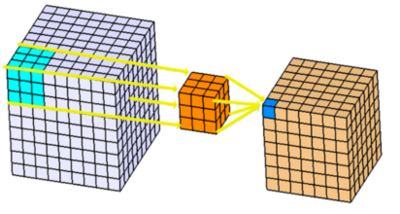

Input Data: ( N x C x D x H x W )

In [ ]:
# class Conv3DAutoencoder(nn.Module):
#     def __init__(self, in_channels, time_steps, latent_size):
#         super(Conv3DAutoencoder, self).__init__()

#         self.encoder = nn.Sequential(
#             nn.Conv3d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Conv3d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
#             nn.ReLU(),
#             nn.Flatten(),
#             nn.Linear(in_features=128 * time_steps * 4 * 4, out_features=latent_size)  
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(in_features=latent_size, out_features=128 * time_steps * 4 * 4),
#             nn.ReLU(),
#             nn.Unflatten(1, (128, time_steps, 4, 4)),  
#             nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),  
#             nn.ReLU(),
#             nn.ConvTranspose3d(in_channels=64, out_channels=in_channels, kernel_size=3, stride=1, padding=1), 
#             nn.Sigmoid()  
#         )

#     def forward(self, x):
#         z = self.encoder(x)  
#         x_reconstructed = self.decoder(z) 
#         return z, x_reconstructed

In [19]:


class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps

        # --- Encoder ---
        self.encoder = nn.Sequential(
            nn.Conv3d(in_channels, 64, kernel_size=3, stride=2, padding=1),  # Downsample (4x4 -> 2x2)
            nn.BatchNorm3d(64),
            nn.ReLU(),

            nn.Conv3d(64, 128, kernel_size=3, stride=2, padding=1),  # Downsample (2x2 -> 1x1)
            nn.BatchNorm3d(128),
            nn.ReLU(),

            nn.Conv3d(128, 256, kernel_size=3, stride=2, padding=1),  # Downsample (1x1 -> 1x1) [keeps spatial size]
            nn.BatchNorm3d(256),
            nn.ReLU(),

            nn.Flatten(),
            nn.Linear(256 * time_steps, 1024),  # Dense layer to compress
            nn.ReLU(),
            nn.Linear(1024, latent_size)  # Latent representation
        )

        # --- Decoder ---
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, 1024),
            nn.ReLU(),
            nn.Linear(1024, 256 * time_steps),  # Dense layer to reshape back
            nn.ReLU(),
            nn.Unflatten(1, (256, time_steps, 1, 1)),  # Reshape back to 3D feature map (256, 7, 1, 1)

            nn.ConvTranspose3d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsample (1x1 -> 2x2)
            nn.BatchNorm3d(128),
            nn.ReLU(),

            nn.ConvTranspose3d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # Upsample (2x2 -> 4x4)
            nn.BatchNorm3d(64),
            nn.ReLU(),

            nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1),  # Maintain spatial size 4x4
            nn.Sigmoid()  # Output layer with sigmoid for reconstruction
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed


### Training

In [ ]:
# Train
device = 'cpu'
epochs = 3
lr = 0.0001
latent_dim=100
channels = 6
time_steps = 7

model = Conv3DAutoencoder(channels, time_steps, latent_dim)
device = torch.device(device)  
model.to(device)

In [ ]:
trained_model, train_losses, test_losses  = train_model_ae(model, dataloader_train, dataloader_test, epochs=epochs, lr=lr, device=device)

### Evaluation

In [ ]:
# Extract features and field numbers
train_features, train_coord_dl = extract_features_ae(trained_model, dataloader_train, device)
test_features, test_coord_dl = extract_features_ae(trained_model, dataloader_test, device)
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, device)

In [ ]:
kmeans = train_kmeans_patches(train_features, n_clusters=2, random_state=401)
# kmeans = KMeans(n_clusters=2, random_state=2)
# kmeans.fit(train_features)

train_patch_predictions = kmeans.predict(train_features.reshape(train_features.size(0), -1).numpy().astype(np.float32))
test_patch_predictions = kmeans.predict(test_features.reshape(test_features.size(0), -1).numpy().astype(np.float32))
eval_patch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

resume

In [ ]:
# Assign field labels
threshold = config.patch_to_field_threshold
train_field_labels = assign_field_labels_ae(train_coord_dl, train_patch_predictions, threshold)
test_field_labels = assign_field_labels_ae(test_coord_dl, test_patch_predictions, threshold)
eval_field_labels = assign_field_labels_ae(eval_coord_dl, eval_patch_predictions, threshold)

In [ ]:
train_field_labels

In [ ]:
accuracy, report, x_y_coords = evaluate_test_labels_ae(eval_field_labels, config.labels_path)
print(f"Test Accuracy: {accuracy}")
print(report)

In [ ]:
# draw_diseased_patches(dataloader_test, x_y_coords)

### Modeling - kmeans

In [ ]:
image_tensor_train.shape

In [ ]:
data_flattened_train = image_tensor_train.reshape(image_tensor_train.size(0), -1).numpy()
data_flattened_train.shape

In [ ]:
kmeans = KMeans(n_clusters=2, random_state=46)
kmeans.fit(data_flattened_train)

In [ ]:
flattened_data_test = image_tensor_eval.reshape(image_tensor_eval.size(0), -1).numpy()

In [ ]:
test_cluster_labels = kmeans.predict(flattened_data_test)

In [ ]:
accuracy, pred_aligned, gt_aligned = get_accuracy(field_numbers_eval, test_cluster_labels, config.labels_path)
accuracy

In [ ]:
pred_aligned[0], gt_aligned[0]

### Feature Extraction